# How the scale parameter relate to period and frequency?


The `scale` parameter used to build the transform is straightforward to use
when it is generally a ramp of integers. However it can be a bit harsh to understand
what it means exactly.
This notebook describe how scale relates to:

- Period
- Frequency
- Child wavelet function
- Cone Of Influence

Intended audience: 

* Engineers or data analysts with mild or no knowledge on wavelets analysis.

## What is the *scale* parameter?

Short answer: The *scale* matches the extent over time of the wavelet. 

To produce the spectrum of an array of values ``data`` you can proceed like this :
```
scaleogram.cws( data, scales=np.arange(1, 100), wavelet='cmor1-1.5' )
```

Under the hood, a mother wavelet function is built and has an extent over time of *base\_duration* (which correspond to 16 samples for ``cmor`` when no ``time`` array is provided in argument list).

Then the Continuous Wavelet Transform (CWT) is performed for each value of ``scales``,
with a child wavelet of duration $base\_duration * s$. 
This child wavelet is convolved (it's like a moving average with the child wavelet instead of ones for the window) with the array ``data``.

**Formal description:** 

>   The mother wavelet is described by the function of time
>
>   $\Psi(t)$
>
>   The child function at scale $s$ is
>
>   $\Psi_{s,x}(t) = \frac{1}{\sqrt{s} } \Psi(\frac{t-x}{s})$
>
>   where $x$ is the shift parameter used to convolve the signal being analysed with the wavelet.



## What is the frequency associated to the scale value $s$ ?

In `pywt.scale2frequency()` the frequency associated to scale $s$ is:

$frequency = \frac{central\_frequency}{s}$

where the $central\_frequency$ is a parameter of the chosen wavelet. See next section.


## What is the *central frequency* of a wavelet?

Short answer: this is the ``C`` parameter in the wavelet name which has generally the form ``nameB-C``
with the ``pywt`` library.
It corresponds to the signal frequency to which the wavelet function will be the most sensitive for scale $s=1$.

The wavelet name used with ``PyWavelet`` allow to add the parameters of the wavelet (from 0 to 3 depending on the function)

For example the name ``cmor1-1.5`` stands for *Complex Morlet* wavelet function with *bandwidth_parameter=1* and *center=1.5[Hz]*.

Let have a look to this function to make that clear.

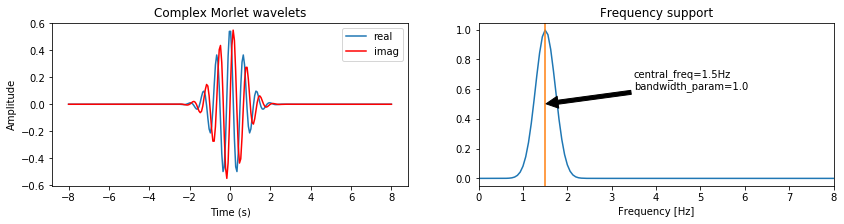

In [1]:
%matplotlib inline

import scaleogram as scg
axes = scg.plot_wav('cmor1-1.5', figsize=(14,3))

* Left plot : the mother wavelet function in time domain
* Right plot: The amplitude of the Fourier transform of the function

In the right plot (Frequency), the yellow vertical line show the location of the peak: this is the *central frequency* of the wavelet.

The bandwidth parameter selects how much the wavelet is sensitive to the frequencies around $C$. On the frequency plot, the bandwidth is represented by the width of the bell shaped curve (also called the *wings*).

Note that $B$ is a parameter, not the real value of the bandwidth...



## Which period value correspond to a given _scale_?

Short answer: $period=\frac{s}{C}$

Wavelet functions are designed to be compact in time and frequency. When looking at the plot above, you can see that the oscillations falls quickly around the center of the function. This *compactness in time* allow the scalogram to show local measurements of the signal **variations**.




## Period or *pseudo period* ?

So if you have followed this notebook from the beginning you may ask at this point:

> Wait?!   
> The previous section says that for *C=1.5Hz* as shown in the upper left plot the period is  
> $period = \frac{1}{1.5} = 0.66s$ .
> 
> If I look on the plot the signal extent is visibly over 4 seconds, not 0.66!  
> 

Well, fair enough!  

At a given scale, the wavelet sensitivity is maximum to the frequency $C$ 
but the bandwidth (parametrized with $B$) is non null, hence it will also probe frequency around the
*central frequency* value. This will appear on scaleogram as a smoothing effect along the Y axis.
This property will also manifest in time domain where the signal decrease *smoothly* to zero
around the maximum oscillation amplitude.

For this reason it is better to use the term of **pseudo period** to describe the
time scale. This property manifest on the *scaleograms* wih some amount of fuzziness
around the signal features which are well localized in time.
This fuzziness is proportional to the scale $s$ (see Example 3).  



## How to read the scaleograms?



### Example 1 : data with two periodic signals

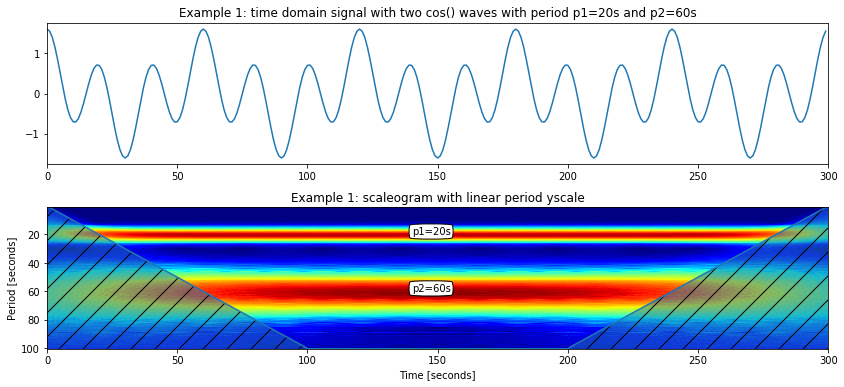

In [2]:
import numpy as np
import matplotlib.pyplot as plt
n = 300
time = np.arange(n)
p1    = 20;  f1 = 1./p1
p2    = 60; f2 = 1./p2
data = np.cos( (2*np.pi*f1) * time) + 0.6*np.cos( (2*np.pi*f2) * time)
wavelet='cmor0.7-1.5'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
fig.subplots_adjust(hspace=0.3)
ax1.plot(time, data); ax1.set_xlim(0, n)
ax1.set_title('Example 1: time domain signal with two cos() waves with period p1=%ds and p2=%ds'%(p1,p2))
ax2 = scg.cws(time, data, scales=np.arange(1, 150), wavelet=wavelet,
        ax=ax2, cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title='Example 1: scaleogram with linear period yscale')
txt = ax2.annotate("p1=%ds" % p1, xy=(n/2,p1), xytext=(n/2-10, p1), bbox=dict(boxstyle="round4", fc="w"))
txt = ax2.annotate("p2=%ds" % p2, xy=(n/2,p2), xytext=(n/2-10, p2), bbox=dict(boxstyle="round4", fc="w"))


* You can observe on Example 1 scaleogram:

   * That the two periodic signals do appear as continuous stripes along the time axis (X).   
    It shows that the wavelet perfectly captures the signal at its frequency of sensitivity.  
    
   * That the visible height of the two signals expands with the scale value.  
    This is absolutely normal as the wavelet signal is scaled by a factor $s$.


### Example 2: Effect of the bandwith parameter (smoothing)

In the second example the bandwidth parameter is multiplied by a factor 3

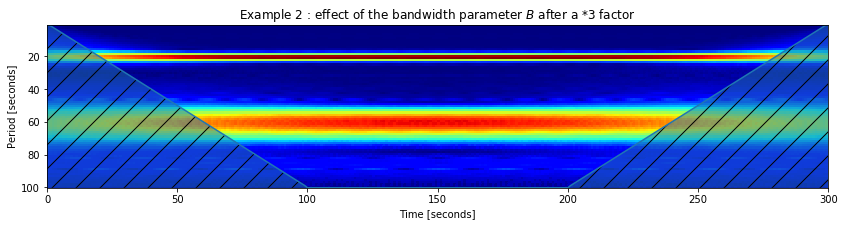

In [3]:

wavelet2 = 'cmor3-1.5'
ax3 = scg.cws(time, data, scales=np.arange(1, 150, 2), wavelet=wavelet2,
        figsize=(14, 3), cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 2 : effect of the bandwidth parameter $B$ after a *3 factor")


You can observe in the scaleogram of example 2 that the height of both stripes has significantly shrunken.
In fact when $B$ increase, the bandwidth decrease!

The bandwidth parameter allow to tune the sensitivity on the period axis (Y). Or in other words the visibl amount of smoothing.

Useful range is between 0.5 and 2 (may vary with the chosen wavelet), other values can cause rippling and various side effects due to numerical limitation from the finite number of samples of the data and wavelet function.


### Example 3 : effect of  holes in data

In real life, data has holes, the observed phenomenon amplitude can vary over time, etc.

The following example has a hole at the beginning and a ramp to zero is applied at the end to get some hint on how these effects do appear on the *scaleogram*. 

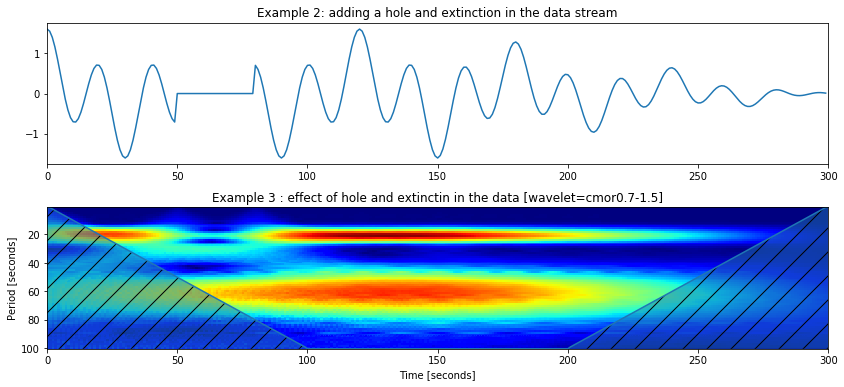

In [4]:
data2 = data
data2[50:80] = 0
data2[150:n] *= np.arange(n-150, 0, -1)/(n-150)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
fig.subplots_adjust(hspace=0.3)
ax1.plot(time, data2); ax1.set_xlim(0, n)
ax1.set_title('Example 2: adding a hole and extinction in the data stream')

ax2 = scg.cws(time, data2, scales=np.arange(1, 150, 2), wavelet=wavelet,
        ax=ax2, cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 3 : effect of hole and extinctin in the data [wavelet="+wavelet+"]")


As you can see, the scale influence not only the sensitivity on the Y axis but has also a smoothing effect on the X axis: the second cos() line at period $p2=60$ does not "see" the first hole in the data, but the signal amplitude has diminished.  

The second observation is the apparition on a spurious line at *period=40*. This is due to the sharp cut applied on the data between 50 and 100 (This effect is called aliasing in frequency).  
Note that missing data filled wit zeros will have this kind of effect.

### Example 3 (bis) : smothing and scale

For a better understanding of the notion of scaling of the wavelet, let have a look at the child wavelets used to produce the stripes at $p1$ (scale=~27) and $p2$ (scale=~90). 

The two child will then be overplotted on the scaleogram at the Y location corresponding to their scale (amplitudes are exaggerated)


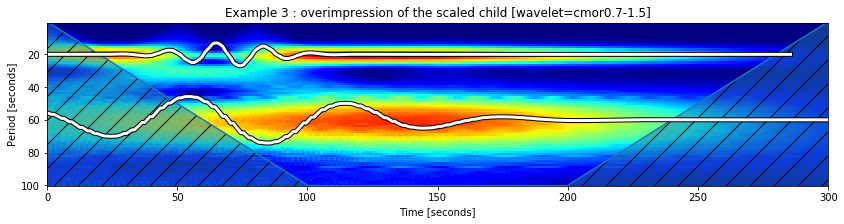

In [5]:
# build the child
s1 = 27; s2 = 90
child1 = scg.child_wav(wavelet, 27)
child2 = scg.child_wav(wavelet, 90)

# plot again Example 3
ax = scg.cws(time, data2, scales=np.arange(1, 150, 2), wavelet=wavelet,
        figsize=(14,3), cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 3 : overimpression of the scaled child [wavelet="+wavelet+"]")

# add the child wavelets over the scaleogram at their corresponding Y location
ax.plot(np.arange(len(child1))-len(child1)/2+70, p1+child1.real*100, '-k', linewidth='5')
ax.plot(np.arange(len(child1))-len(child1)/2+70, p1+child1.real*100, '-w', linewidth='3')
ax.plot(np.arange(len(child2))-len(child2)/2+70, p2+child2.real*200, '-k', linewidth='5')
ax.plot(np.arange(len(child2))-len(child2)/2+70, p2+child2.real*200, '-w', linewidth='3')
xlim = ax.set_xlim(0,n)

Now it is clearly visible that the signal extension of the child match the observed smoothing on the X axis.

One can note also that the support of the wavelets is about 400s and 1400s for the scales 27 and 90 respectively.
It is larger than the signal being studied, but as most of the child values are close to zero, 
it is rather the *pseudo period* length which has to be considered.

## Example 4 : Tip - passing the Y axis in logscale

The ``scaleogram`` module has a robust support for logarithmic scale axes.

With logscale on Y axis, the bandwith will have the same height at all scales which may be helpful for data interpretation.

Let's try it by setting the ``yscale='log'`` parameter!

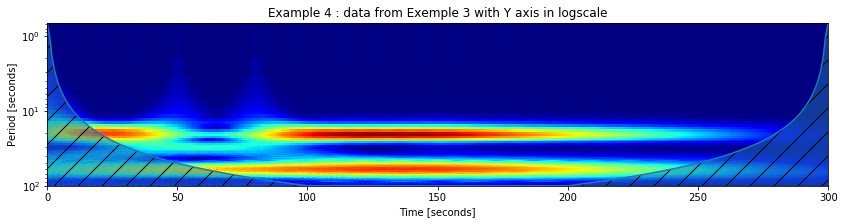

In [6]:
ax2 = scg.cws(time, data2, scales=np.arange(1, 150, 2), wavelet=wavelet,
        figsize=(14, 3), cmap="jet", cbar=None, ylabel="Period [seconds]", xlabel="Time [seconds]",
        title="Example 4 : data from Exemple 3 with Y axis in logscale",
        yscale='log')

OK now the two cos() signals appear with the same visual height on the scaleogram!  
The drawback is that now the lecture precision of the period is lessened.

Note that the smoothing effect on the time axis (X) is still present.

## Using the Cone Of Influence

You may have noticed that the borders of the spectrum are covered with an (optional) mask.
This area is called the Cone Of Influence (COI) and represents the locations where the data is strongly affected by border effects due to the extent in time of the child wavelet.

As a rule of thumb, you can use the COI as a visual marker to appreciate the precision in time at a given scale.

## Conclusion


In this notebook we have seen the meaning of the scale parameter. It has been considered in relation to the frequency and period of the meaningful features in the data.

The main idea is that in a *scaleogram* there is a compromise between time and frequency resolution which depend on the scale. You can use the COI to help in appreciating visually this compromise.

I hope this page has been useful for you, have fun with wavelet based analysis!


## See also

* [Continuous Wavelet Transform (CWT)](https://www.weisang.com/fr/dokumentation/timefreqspectrumalgorithmscwt_fr/) Another page with very nice examples related to the time/frequency compromise

* [Continuous Wavelet Transform and Scale-Based Analysis](https://fr.mathworks.com/help/wavelet/gs/continuous-wavelet-transform-and-scale-based-analysis.html) The matlab page with a clear description of the formalism used with CWT


## Author

Alexandre Sauvé (2019)

The [scaleogram](http://github.com/alsauve/scaleogram) module
